In [ ]:
import numpy as np
import os
import sys
import copy

import torch
torch.set_num_threads(os.cpu_count())
from torch import nn

import json

import matplotlib as mpl
import matplotlib.pyplot as plt

from pipnet import data
from pipnet import model
from pipnet import utils

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
mod = "PIPNet_2022_09_28_2_layers"

in_dir = f"../../data/1D/{mod}/"
fig_dir = f"../../figures/1D/{mod}/"

batch_size = 16
n_batch = 64
n_show = 64

epoch = 200
eval_all_steps = False

eval_peaks = True
n_peaks = np.arange(20) + 1

eval_wr = True
wrs = ["wr1", "wr2", "wr1+wr2"]

eval_mas_high = True
high_mas = [40000., 50000., 60000., 70000., 80000., 90000., 100000.]

eval_mas_low = True
low_mas = [20000., 30000., 40000., 50000., 60000., 70000., 80000., 90000.]

eval_nw = True
nw_max = 30

eval_noise = True
noise_levels = [0., 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2]

eval_shift_noise = True
shift_noise_levels = [0., 10., 20., 30., 40., 50., 60., 70., 80., 90., 100.]

eval_lw_noise = True
lw_noise_levels = [0., 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

eval_shift = True
shift_values = [True, False]
shift_labels = ["Shift", "No shift"]

eval_constant = True

iso_pars = dict(
    td = 512,
    Fs = 12_800,
    nmin = 1,
    nmax = 15,
    freq_range = [2_000., 10_000.],
    gmin = 1,
    gmax = 1,
    spread = 5.,
    lw_range = [[5e1, 2e2], [1e2, 5e2], [1e2, 1e3]],
    lw_probs = [0.7, 0.2, 0.1],
    int_range = [0.5, 1.], # Intensity
    phase = 0.,
    debug = False,
)

mas_pars = dict(
    nw = 24,
    mas_w_range = [30_000., 100_000.],
    random_mas = True,
    mas_phase_p = 0.5,
    mas_phase_scale = 0.05,
    
    # First-order MAS-dependent parameters
    mas1_lw_range = [[1e7, 5e7], [5e7, 1e8]],
    mas1_lw_probs = [0.8, 0.2],
    mas1_m_range = [[0., 0.], [0., 1e4], [1e4, 5e4]],
    mas1_m_probs = [0.1, 0.1, 0.8],
    mas1_s_range = [[-1e7, 1e7]],
    mas1_s_probs = [1.],

    # Second-order MAS-dependent parameters
    mas2_prob = 1.,
    mas2_lw_range = [[0., 0.], [1e11, 5e11]],
    mas2_lw_probs = [0.5, 0.5],
    mas2_m_range = [[0., 0.], [1e8, 5e8]],
    mas2_m_probs = [0.8, 0.2],
    mas2_s_range = [[0., 0.], [-2e10, 2e10]],
    mas2_s_probs = [0.8, 0.2],
    
    # Other MAS-dependent parameters
    non_mas_p = 0.5,
    non_mas_m_trends = ["constant", "increase", "decrease"],
    non_mas_m_probs = [0.34, 0.33, 0.33],
    non_mas_m_range = [0., 1.],
    
    int_decrease_p = 0.1,
    int_decrease_scale =[0.3, 0.7],
    debug = False,
)

with open(f"{in_dir}data_pars.json", "r") as F:
    data_pars = json.load(F)

data_pars["iso_pars"] = iso_pars
data_pars["mas_pars"] = mas_pars
data_pars["noise"] = 0.
data_pars["mas_l_noise"] = 0.05
data_pars["mas_s_noise"] = 25.
data_pars["gen_mas_shifts"] = False

loss_pars1 = dict(
    trg_fuzz = 0.,
    trg_fuzz_len = 0,
    ndim = 1,
    exp = 1.0,
    offset = 1.0,
    factor = 0.0,
    int_w = 1.0,
    int_exp = 1.0,
    return_components = True,
    device = device,
)

loss_pars2 = dict(
    trg_fuzz = 0.,
    trg_fuzz_len = 0,
    ndim = 1,
    exp = 2.0,
    offset = 1.0,
    factor = 0.0,
    int_w = 1.0,
    int_exp = 2.0,
    return_components = True,
    device = device,
)

loss1 = model.PIPLoss(**loss_pars1)
loss2 = model.PIPLoss(**loss_pars2)

In [ ]:
if not os.path.exists(in_dir):
    raise ValueError(f"Unknown model: {mod}")
    
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

fdir = fig_dir + "evaluation/"

if not os.path.exists(fdir):
    os.mkdir(fdir)

In [ ]:
with open(in_dir + "model_pars.json", "r") as F:
    model_pars = json.load(F)
model_pars["noise"] = 0.
model_pars["return_all_layers"] = eval_all_steps

net = model.ConvLSTMEnsemble(**model_pars)
net.load_state_dict(torch.load(in_dir + f"epoch_{epoch}_network", map_location=device))
net = net.eval()

0.0


NameError: name 'epoch' is not defined

In [7]:
def compute_cos_sim(y1, y2):
    
    sim = nn.CosineSimilarity(dim=-1)
    
    return torch.mean(sim(y1, y2))

In [8]:
def plot_results(x, iso_maes, int_maes, iso_mses, cos_sims, norm=False, xlog=False, xticks=None, xticklabels=None, xlabel="x", show=True, save=None):
    
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4)
    
    ax1.plot(x, iso_maes, ".")
    ax2.plot(x, int_maes, ".")
    ax3.plot(x, iso_mses, ".")
    ax4.plot(x, cos_sims, ".")
    
    if norm:
        ax1.plot(x, iso_maes / x, ".")
        ax2.plot(x, int_maes / x, ".")
        ax3.plot(x, iso_mses / x, ".")
        ax4.plot(x, cos_sims, ".")
    
    ax1.set_ylim(0., 1.1*np.max(iso_maes))
    ax2.set_ylim(0., 1.1*np.max(int_maes))
    ax3.set_ylim(0., 1.1*np.max(iso_mses))
    ax4.set_ylim(0., 1.)

    ax1.set_xlabel(xlabel)
    ax2.set_xlabel(xlabel)
    ax3.set_xlabel(xlabel)
    ax4.set_xlabel(xlabel)
    
    if xticks is not None:
        ax1.set_xticks(xticks)
        ax2.set_xticks(xticks)
        ax3.set_xticks(xticks)
        ax4.set_xticks(xticks)
        if xticklabels is not None:
            ax1.set_xticklabels(xticklabels)
            ax2.set_xticklabels(xticklabels)
            ax3.set_xticklabels(xticklabels)
            ax4.set_xticklabels(xticklabels)
    
    ax1.set_ylabel("Spectrum MAE")
    ax2.set_ylabel("Integral MAE")
    ax3.set_ylabel("Spectrum MSE")
    ax4.set_ylabel("Cosine similarity")
    
    if norm:
        ax1.legend(["Absolute", "Normalised"])
        ax2.legend(["Absolute", "Normalised"])
        ax3.legend(["Absolute", "Normalised"])
        ax4.legend(["Absolute", "Normalised"])
    
    if xlog:
        ax1.set_xscale("log")
        ax2.set_xscale("log")
        ax3.set_xscale("log")
        ax4.set_xscale("log")
    
    fig.tight_layout()
    if show:
        plt.show()
    if save is not None:
        fig.savefig(save)
        
        pp = ""
        for xi, iso_mae, int_mae, iso_mse, cos_sim in zip(x, iso_maes, int_maes, iso_mses, cos_sims):
            
            if xticklabels is not None:
                xi = xticklabels[xi].replace(" ", "_")
            
            if norm:
                pp += f"{xi}\t{iso_mae:.4e}\t{int_mae:4e}\t{iso_mse:.4e}\t{cos_sim:.4e}\t"
                pp += f"{iso_mae/xi:.4e}\t{int_mae/xi:4e}\t{iso_mse/xi:.4e}\t{cos_sim/xi:.4e}\n"
            else:
                pp += f"{xi}\t{iso_mae:.4e}\t{int_mae:4e}\t{iso_mse:.4e}\t{cos_sim:.4e}\n"
        
        with open(".".join(save.split(".")[:-1]) + ".txt", "w") as F:
            F.write(pp)
            
    plt.close()

# Vary number of peaks

Generating 1 peaks
  Batch 1/4
  Batch 2/4
  Batch 3/4
  Batch 4/4


KeyboardInterrupt: 

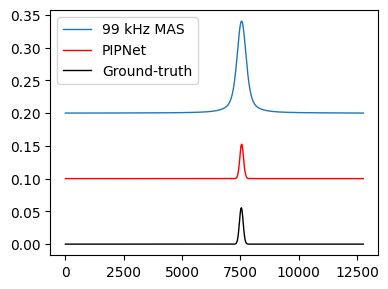

In [7]:
iso_maes = []
int_maes = []
iso_mses = []
cos_sims = []

if eval_wr:
    
    for peaks in n_peaks:
        
        np.random.seed(1)
        
        d = fdir + f"npeaks/{peaks}_peaks/"
        if not os.path.exists(d):
            os.makedirs(d)
        
        print(f"Generating {peaks} peaks")
        
        # Update data parameters
        data_pars2 = copy.deepcopy(data_pars)
        data_pars2["iso_pars"]["nmin"] = peaks
        data_pars2["iso_pars"]["nmax"] = peaks
        dataset = data.Dataset(**data_pars2)
        
        X = []
        y = []
        y_pred = []
        y_std = []
        ys_pred = []
        for ibatch in range(n_batch):
            # Generate dataset
            Xi, yi = dataset.generate_batch(size=batch_size)
            
            print(f"  Batch {ibatch + 1}/{n_batch}")

            # Make predictions
            with torch.no_grad():
                yi_pred, yi_std, yis_pred = net(Xi)

            if net.return_all_layers:
                if net.ndim == 1:
                    yi = yi.repeat((1, yi_pred.shape[1], 1))
                elif net.ndim == 2:
                    yi = yi.repeat((1, yi_pred.shape[1], 1, 1))
            
            X.append(Xi)
            y.append(yi)
            y_pred.append(yi_pred)
            y_std.append(yi_std)
            ys_pred.append(yis_pred)
        
        X = torch.cat(X)
        y = torch.cat(y)
        y_pred = torch.cat(y_pred)
        y_std = torch.cat(y_std)
        ys_pred = torch.cat(ys_pred, dim=1)

        for ishow in range(n_show):
            utils.plot_1d_iso_prediction(
                X[ishow],
                y_pred[ishow],
                y_std[ishow],
                y_trg = y[ishow, 0],
                pred_scale=0.5,
                trg_scale=0.5,
                X_offset = 0.2,
                pred_offset=0.1,
                xvals=dataset.f,
                wr_factor=dataset.norm_wr,
                show=False,
                save=f"{d}sample_{ishow+1}.pdf"
            )
            
        # Compute loss
        if net.is_ensemble:
            ys = torch.cat([torch.unsqueeze(y.clone(), 0) for _ in range(ys_pred.shape[0])])
            _, [iso_mae, int_mae] = loss1(ys_pred, ys)
            _, [iso_mse, _] = loss2(ys_pred, ys)
            
        else:
            _, [iso_mae, int_mae] = loss1(y_pred, y)
            _, [iso_mse, _] = loss2(y_pred, y)
        
        iso_maes.append(iso_mae)
        int_maes.append(int_mae)
        iso_mses.append(iso_mse)
        cos_sims.append(compute_cos_sim(y_pred, y))
        
    iso_maes = np.array(iso_maes)
    int_maes = np.array(int_maes)
    iso_mses = np.array(iso_mses)
    cos_sims = np.array(cos_sims)
    
    plot_results(
        n_peaks,
        iso_maes,
        int_maes,
        iso_mses,
        cos_sims,
        norm=True,
        xlabel="Number of peaks",
        show=False,
        save=f"{fdir}eval_npeaks.pdf"
    )

# w1 vs w2

In [9]:
iso_maes = []
int_maes = []
iso_mses = []
cos_sims = []

if eval_peaks:
    
    for wr in wrs:
        
        np.random.seed(1)
        
        d = fdir + f"w12/{wr.replace('+', '_')}/"
        if not os.path.exists(d):
            os.makedirs(d)
        
        print(f"Generating {wr}")
        
        # Update data parameters
        data_pars2 = copy.deepcopy(data_pars)
        if "wr1" not in wr:
            data_pars2["mas_pars"]["mas1_lw_range"] = [[0., 0.]]
            data_pars2["mas_pars"]["mas1_lw_probs"] = [1.]
            data_pars2["mas_pars"]["mas1_m_range"] = [[0., 0.]]
            data_pars2["mas_pars"]["mas1_m_probs"] = [1.]
            data_pars2["mas_pars"]["mas1_s_range"] = [[0., 0.]]
            data_pars2["mas_pars"]["mas1_s_probs"] = [1.]
        
        if "wr2" not in wr:
            data_pars2["mas_pars"]["mas2_prob"] = 0.
        else:
            data_pars2["mas_pars"]["mas2_lw_range"] = [[1e11, 5e11]]
            data_pars2["mas_pars"]["mas2_lw_probs"] = [1.]
        dataset = data.Dataset(**data_pars2)
        
        X = []
        y = []
        y_pred = []
        y_std = []
        ys_pred = []
        for ibatch in range(n_batch):
            # Generate dataset
            Xi, yi = dataset.generate_batch(size=batch_size)
            
            print(f"  Batch {ibatch + 1}/{n_batch}")

            # Make predictions
            with torch.no_grad():
                yi_pred, yi_std, yis_pred = net(Xi)

            if net.return_all_layers:
                if net.ndim == 1:
                    yi = yi.repeat((1, yi_pred.shape[1], 1))
                elif net.ndim == 2:
                    yi = yi.repeat((1, yi_pred.shape[1], 1, 1))
            
            X.append(Xi)
            y.append(yi)
            y_pred.append(yi_pred)
            y_std.append(yi_std)
            ys_pred.append(yis_pred)
        
        X = torch.cat(X)
        y = torch.cat(y)
        y_pred = torch.cat(y_pred)
        y_std = torch.cat(y_std)
        ys_pred = torch.cat(ys_pred, dim=1)
        
        for ishow in range(n_show):
            utils.plot_1d_iso_prediction(
                X[ishow],
                y_pred[ishow],
                y_std[ishow],
                y_trg = y[ishow, 0],
                pred_scale=0.5,
                trg_scale=0.5,
                X_offset = 0.2,
                pred_offset=0.1,
                xvals=dataset.f,
                wr_factor=dataset.norm_wr,
                show=False,
                save=f"{d}sample_{ishow+1}.pdf"
            )
            
        # Compute loss
        if net.is_ensemble:
            ys = torch.cat([torch.unsqueeze(y.clone(), 0) for _ in range(ys_pred.shape[0])])
            _, [iso_mae, int_mae] = loss1(ys_pred, ys)
            _, [iso_mse, _] = loss2(ys_pred, ys)
            
        else:
            _, [iso_mae, int_mae] = loss1(y_pred, y)
            _, [iso_mse, _] = loss2(y_pred, y)
        
        iso_maes.append(iso_mae)
        int_maes.append(int_mae)
        iso_mses.append(iso_mse)
        cos_sims.append(compute_cos_sim(y_pred, y))
        
    iso_maes = np.array(iso_maes)
    int_maes = np.array(int_maes)
    iso_mses = np.array(iso_mses)
    cos_sims = np.array(cos_sims)
    
    plot_results(
        np.arange(len(wrs)),
        iso_maes,
        int_maes,
        iso_mses,
        cos_sims,xticks=np.arange(len(wrs)),
        xticklabels=wrs,
        xlabel="MAS dependence",
        show=False,
        save=f"{fdir}eval_wr12.pdf"
    )

Generating wr1
  Batch 1/4
  Batch 2/4
  Batch 3/4
  Batch 4/4
Generating wr2
  Batch 1/4
  Batch 2/4
  Batch 3/4
  Batch 4/4
Generating wr1+wr2
  Batch 1/4
  Batch 2/4
  Batch 3/4
  Batch 4/4


# Vary highest MAS

In [ ]:
iso_maes = []
int_maes = []
iso_mses = []
cos_sims = []

if eval_mas_high:
    
    for wr in high_mas:
        
        np.random.seed(1)
        
        d = fdir + f"high_mas/{wr/1000.:.0f}_kHz/"
        if not os.path.exists(d):
            os.makedirs(d)
        
        print(f"Generating highest MAS rate {wr/1000.:.0f} kHz")
        
        # Update data parameters
        data_pars2 = copy.deepcopy(data_pars)
        wr0 = data_pars["mas_pars"]["mas_w_range"]
        wr1 = [wr0[0], wr]
        nw0 = data_pars["mas_pars"]["nw"]
        nw1 = int(nw0 * (wr1[1]-wr1[0]) / (wr0[1]-wr0[0]))
        nw1 = max(model_pars["batch_input"]+1, nw1)
        
        data_pars2["mas_pars"]["mas_w_range"] = wr1
        data_pars2["mas_pars"]["nw"] = nw1
        dataset = data.Dataset(**data_pars2)
        
        X = []
        y = []
        y_pred = []
        y_std = []
        ys_pred = []
        for ibatch in range(n_batch):
            # Generate dataset
            Xi, yi = dataset.generate_batch(size=batch_size)
            
            print(f"  Batch {ibatch + 1}/{n_batch}")

            # Make predictions
            with torch.no_grad():
                yi_pred, yi_std, yis_pred = net(Xi)

            if net.return_all_layers:
                if net.ndim == 1:
                    yi = yi.repeat((1, yi_pred.shape[1], 1))
                elif net.ndim == 2:
                    yi = yi.repeat((1, yi_pred.shape[1], 1, 1))
            
            X.append(Xi)
            y.append(yi)
            y_pred.append(yi_pred)
            y_std.append(yi_std)
            ys_pred.append(yis_pred)
        
        X = torch.cat(X)
        y = torch.cat(y)
        y_pred = torch.cat(y_pred)
        y_std = torch.cat(y_std)
        ys_pred = torch.cat(ys_pred, dim=1)
        
        for ishow in range(n_show):
            utils.plot_1d_iso_prediction(
                X[ishow],
                y_pred[ishow],
                y_std[ishow],
                y_trg = y[ishow, 0],
                pred_scale=0.5,
                trg_scale=0.5,
                X_offset = 0.2,
                pred_offset=0.1,
                xvals=dataset.f,
                wr_factor=dataset.norm_wr,
                show=False,
                save=f"{d}sample_{ishow+1}.pdf"
            )
            
        # Compute loss
        if net.is_ensemble:
            ys = torch.cat([torch.unsqueeze(y.clone(), 0) for _ in range(ys_pred.shape[0])])
            _, [iso_mae, int_mae] = loss1(ys_pred, ys)
            _, [iso_mse, _] = loss2(ys_pred, ys)
            
        else:
            _, [iso_mae, int_mae] = loss1(y_pred, y)
            _, [iso_mse, _] = loss2(y_pred, y)
        
        iso_maes.append(iso_mae)
        int_maes.append(int_mae)
        iso_mses.append(iso_mse)
        cos_sims.append(compute_cos_sim(y_pred, y))
        
    iso_maes = np.array(iso_maes)
    int_maes = np.array(int_maes)
    iso_mses = np.array(iso_mses)
    cos_sims = np.array(cos_sims)
    
    plot_results(
        high_mas,
        iso_maes,
        int_maes,
        iso_mses,
        cos_sims,
        xlabel="Highest MAS rate",
        show=False,
        save=f"{fdir}eval_mas_high.pdf")

# Vary highest MAS, same number of spectra

In [ ]:
iso_maes = []
int_maes = []
iso_mses = []
cos_sims = []

if eval_mas_high:
    
    for wr in high_mas:
        
        np.random.seed(1)
        
        d = fdir + f"high_mas_same_nw/{wr/1000.:.0f}_kHz/"
        if not os.path.exists(d):
            os.makedirs(d)
        
        print(f"Generating highest MAS rate {wr/1000.:.0f} kHz")
        
        # Update data parameters
        data_pars2 = copy.deepcopy(data_pars)
        wr0 = data_pars["mas_pars"]["mas_w_range"]
        wr1 = [wr0[0], wr]
        
        data_pars2["mas_pars"]["mas_w_range"] = wr1
        dataset = data.Dataset(**data_pars2)
        
        X = []
        y = []
        y_pred = []
        y_std = []
        ys_pred = []
        for ibatch in range(n_batch):
            # Generate dataset
            Xi, yi = dataset.generate_batch(size=batch_size)
            
            print(f"  Batch {ibatch + 1}/{n_batch}")

            # Make predictions
            with torch.no_grad():
                yi_pred, yi_std, yis_pred = net(Xi)

            if net.return_all_layers:
                if net.ndim == 1:
                    yi = yi.repeat((1, yi_pred.shape[1], 1))
                elif net.ndim == 2:
                    yi = yi.repeat((1, yi_pred.shape[1], 1, 1))
            
            X.append(Xi)
            y.append(yi)
            y_pred.append(yi_pred)
            y_std.append(yi_std)
            ys_pred.append(yis_pred)
        
        X = torch.cat(X)
        y = torch.cat(y)
        y_pred = torch.cat(y_pred)
        y_std = torch.cat(y_std)
        ys_pred = torch.cat(ys_pred, dim=1)
        
        for ishow in range(n_show):
            utils.plot_1d_iso_prediction(
                X[ishow],
                y_pred[ishow],
                y_std[ishow],
                y_trg = y[ishow, 0],
                pred_scale=0.5,
                trg_scale=0.5,
                X_offset = 0.2,
                pred_offset=0.1,
                xvals=dataset.f,
                wr_factor=dataset.norm_wr,
                show=False,
                save=f"{d}sample_{ishow+1}.pdf"
            )
            
        # Compute loss
        if net.is_ensemble:
            ys = torch.cat([torch.unsqueeze(y.clone(), 0) for _ in range(ys_pred.shape[0])])
            _, [iso_mae, int_mae] = loss1(ys_pred, ys)
            _, [iso_mse, _] = loss2(ys_pred, ys)
            
        else:
            _, [iso_mae, int_mae] = loss1(y_pred, y)
            _, [iso_mse, _] = loss2(y_pred, y)
        
        iso_maes.append(iso_mae)
        int_maes.append(int_mae)
        iso_mses.append(iso_mse)
        cos_sims.append(compute_cos_sim(y_pred, y))
        
    iso_maes = np.array(iso_maes)
    int_maes = np.array(int_maes)
    iso_mses = np.array(iso_mses)
    cos_sims = np.array(cos_sims)
    
    plot_results(
        high_mas,
        iso_maes,
        int_maes,
        iso_mses,
        cos_sims,
        xlabel="Highest MAS rate",
        show=False,
        save=f"{fdir}eval_mas_high_same_nw.pdf")

# Vary lowest MAS

In [ ]:
iso_maes = []
int_maes = []
iso_mses = []
cos_sims = []

if eval_mas_low:
    
    for wr in low_mas:
        
        np.random.seed(1)
        
        d = fdir + f"low_mas/{wr/1000.:.0f}_kHz/"
        if not os.path.exists(d):
            os.makedirs(d)
        
        print(f"Generating lowest MAS rate {wr/1000.:.0f} kHz")
        
        # Update data parameters
        data_pars2 = copy.deepcopy(data_pars)
        wr0 = data_pars["mas_pars"]["mas_w_range"]
        wr1 = [wr, wr0[1]]
        nw0 = data_pars["mas_pars"]["nw"]
        nw1 = int(nw0 * (wr1[1]-wr1[0]) / (wr0[1]-wr0[0]))
        nw1 = max(model_pars["batch_input"]+1, nw1)
        
        data_pars2["mas_pars"]["mas_w_range"] = wr1
        data_pars2["mas_pars"]["nw"] = nw1
        dataset = data.Dataset(**data_pars2)
        
        X = []
        y = []
        y_pred = []
        y_std = []
        ys_pred = []
        for ibatch in range(n_batch):
            # Generate dataset
            Xi, yi = dataset.generate_batch(size=batch_size)
            
            print(f"  Batch {ibatch + 1}/{n_batch}")

            # Make predictions
            with torch.no_grad():
                yi_pred, yi_std, yis_pred = net(Xi)

            if net.return_all_layers:
                if net.ndim == 1:
                    yi = yi.repeat((1, yi_pred.shape[1], 1))
                elif net.ndim == 2:
                    yi = yi.repeat((1, yi_pred.shape[1], 1, 1))
            
            X.append(Xi)
            y.append(yi)
            y_pred.append(yi_pred)
            y_std.append(yi_std)
            ys_pred.append(yis_pred)
        
        X = torch.cat(X)
        y = torch.cat(y)
        y_pred = torch.cat(y_pred)
        y_std = torch.cat(y_std)
        ys_pred = torch.cat(ys_pred, dim=1)
        
        for ishow in range(n_show):
            utils.plot_1d_iso_prediction(
                X[ishow],
                y_pred[ishow],
                y_std[ishow],
                y_trg = y[ishow, 0],
                pred_scale=0.5,
                trg_scale=0.5,
                X_offset = 0.2,
                pred_offset=0.1,
                xvals=dataset.f,
                wr_factor=dataset.norm_wr,
                show=False,
                save=f"{d}sample_{ishow+1}.pdf"
            )
            
        # Compute loss
        if net.is_ensemble:
            ys = torch.cat([torch.unsqueeze(y.clone(), 0) for _ in range(ys_pred.shape[0])])
            _, [iso_mae, int_mae] = loss1(ys_pred, ys)
            _, [iso_mse, _] = loss2(ys_pred, ys)
            
        else:
            _, [iso_mae, int_mae] = loss1(y_pred, y)
            _, [iso_mse, _] = loss2(y_pred, y)
        
        iso_maes.append(iso_mae)
        int_maes.append(int_mae)
        iso_mses.append(iso_mse)
        cos_sims.append(compute_cos_sim(y_pred, y))
        
    iso_maes = np.array(iso_maes)
    int_maes = np.array(int_maes)
    iso_mses = np.array(iso_mses)
    cos_sims = np.array(cos_sims)
    
    plot_results(
        low_mas,
        iso_maes,
        int_maes,
        iso_mses,
        cos_sims,
        xlabel="Lowest MAS rate",
        show=False,
        save=f"{fdir}eval_mas_low.pdf")

# Vary lowest MAS, same number of spectra

In [ ]:
iso_maes = []
int_maes = []
iso_mses = []
cos_sims = []

if eval_mas_low:
    
    for wr in low_mas:
        
        np.random.seed(1)
        
        d = fdir + f"low_mas_same_nw/{wr/1000.:.0f}_kHz/"
        if not os.path.exists(d):
            os.makedirs(d)
        
        print(f"Generating lowest MAS rate {wr/1000.:.0f} kHz")
        
        # Update data parameters
        data_pars2 = copy.deepcopy(data_pars)
        wr0 = data_pars["mas_pars"]["mas_w_range"]
        wr1 = [wr, wr0[1]]
        
        data_pars2["mas_pars"]["mas_w_range"] = wr1
        dataset = data.Dataset(**data_pars2)
        
        X = []
        y = []
        y_pred = []
        y_std = []
        ys_pred = []
        for ibatch in range(n_batch):
            # Generate dataset
            Xi, yi = dataset.generate_batch(size=batch_size)
            
            print(f"  Batch {ibatch + 1}/{n_batch}")

            # Make predictions
            with torch.no_grad():
                yi_pred, yi_std, yis_pred = net(Xi)

            if net.return_all_layers:
                if net.ndim == 1:
                    yi = yi.repeat((1, yi_pred.shape[1], 1))
                elif net.ndim == 2:
                    yi = yi.repeat((1, yi_pred.shape[1], 1, 1))
            
            X.append(Xi)
            y.append(yi)
            y_pred.append(yi_pred)
            y_std.append(yi_std)
            ys_pred.append(yis_pred)
        
        X = torch.cat(X)
        y = torch.cat(y)
        y_pred = torch.cat(y_pred)
        y_std = torch.cat(y_std)
        ys_pred = torch.cat(ys_pred, dim=1)
        
        for ishow in range(n_show):
            utils.plot_1d_iso_prediction(
                X[ishow],
                y_pred[ishow],
                y_std[ishow],
                y_trg = y[ishow, 0],
                pred_scale=0.5,
                trg_scale=0.5,
                X_offset = 0.2,
                pred_offset=0.1,
                xvals=dataset.f,
                wr_factor=dataset.norm_wr,
                show=False,
                save=f"{d}sample_{ishow+1}.pdf"
            )
            
        # Compute loss
        if net.is_ensemble:
            ys = torch.cat([torch.unsqueeze(y.clone(), 0) for _ in range(ys_pred.shape[0])])
            _, [iso_mae, int_mae] = loss1(ys_pred, ys)
            _, [iso_mse, _] = loss2(ys_pred, ys)
            
        else:
            _, [iso_mae, int_mae] = loss1(y_pred, y)
            _, [iso_mse, _] = loss2(y_pred, y)
        
        iso_maes.append(iso_mae)
        int_maes.append(int_mae)
        iso_mses.append(iso_mse)
        cos_sims.append(compute_cos_sim(y_pred, y))
        
    iso_maes = np.array(iso_maes)
    int_maes = np.array(int_maes)
    iso_mses = np.array(iso_mses)
    cos_sims = np.array(cos_sims)
    
    plot_results(
        low_mas,
        iso_maes,
        int_maes,
        iso_mses,
        cos_sims,
        xlabel="Lowest MAS rate",
        show=False,
        save=f"{fdir}eval_mas_low_same_nw.pdf")

# Vary number of spectra

In [ ]:
iso_maes = []
int_maes = []
iso_mses = []
cos_sims = []

if eval_nw:
    
    for nw in np.arange(model_pars["batch_input"], nw_max+1):
        
        np.random.seed(1)
        
        d = fdir + f"n_mas/{nw}/"
        if not os.path.exists(d):
            os.makedirs(d)
        
        print(f"Generating {nw} MAS spectra")
        
        # Update data parameters
        data_pars2 = copy.deepcopy(data_pars)
        data_pars2["mas_pars"]["nw"] = nw
        dataset = data.Dataset(**data_pars2)
        
        X = []
        y = []
        y_pred = []
        y_std = []
        ys_pred = []
        for ibatch in range(n_batch):
            # Generate dataset
            Xi, yi = dataset.generate_batch(size=batch_size)
            
            print(f"  Batch {ibatch + 1}/{n_batch}")

            # Make predictions
            with torch.no_grad():
                yi_pred, yi_std, yis_pred = net(Xi)

            if net.return_all_layers:
                if net.ndim == 1:
                    yi = yi.repeat((1, yi_pred.shape[1], 1))
                elif net.ndim == 2:
                    yi = yi.repeat((1, yi_pred.shape[1], 1, 1))
            
            X.append(Xi)
            y.append(yi)
            y_pred.append(yi_pred)
            y_std.append(yi_std)
            ys_pred.append(yis_pred)
        
        X = torch.cat(X)
        y = torch.cat(y)
        y_pred = torch.cat(y_pred)
        y_std = torch.cat(y_std)
        ys_pred = torch.cat(ys_pred, dim=1)
        
        for ishow in range(n_show):
            utils.plot_1d_iso_prediction(
                X[ishow],
                y_pred[ishow],
                y_std[ishow],
                y_trg = y[ishow, 0],
                pred_scale=0.5,
                trg_scale=0.5,
                X_offset = 0.2,
                pred_offset=0.1,
                xvals=dataset.f,
                wr_factor=dataset.norm_wr,
                show=False,
                save=f"{d}sample_{ishow+1}.pdf"
            )
            
        # Compute loss
        if net.is_ensemble:
            ys = torch.cat([torch.unsqueeze(y.clone(), 0) for _ in range(ys_pred.shape[0])])
            _, [iso_mae, int_mae] = loss1(ys_pred, ys)
            _, [iso_mse, _] = loss2(ys_pred, ys)
            
        else:
            _, [iso_mae, int_mae] = loss1(y_pred, y)
            _, [iso_mse, _] = loss2(y_pred, y)
        
        iso_maes.append(iso_mae)
        int_maes.append(int_mae)
        iso_mses.append(iso_mse)
        cos_sims.append(compute_cos_sim(y_pred, y))
        
    iso_maes = np.array(iso_maes)
    int_maes = np.array(int_maes)
    iso_mses = np.array(iso_mses)
    cos_sims = np.array(cos_sims)
    
    plot_results(
        np.arange(model_pars["batch_input"], nw_max+1),
        iso_maes,
        int_maes,
        iso_mses,
        cos_sims,
        xlabel="Number of MAS spectra",
        show=False,
        save=f"{fdir}eval_n_mas.pdf")

# Vary noise

In [ ]:
iso_maes = []
int_maes = []
iso_mses = []
cos_sims = []

if eval_noise:
    
    for noise in noise_levels:
        
        np.random.seed(1)
        
        d = fdir + f"noise/{noise}/"
        if not os.path.exists(d):
            os.makedirs(d)
        
        print(f"Generating noise level {noise}")
        
        # Update data parameters
        data_pars2 = copy.deepcopy(data_pars)
        data_pars2["noise"] = noise
        dataset = data.Dataset(**data_pars2)
        
        X = []
        y = []
        y_pred = []
        y_std = []
        ys_pred = []
        for ibatch in range(n_batch):
            # Generate dataset
            Xi, yi = dataset.generate_batch(size=batch_size)
            
            print(f"  Batch {ibatch + 1}/{n_batch}")

            # Make predictions
            with torch.no_grad():
                yi_pred, yi_std, yis_pred = net(Xi)

            if net.return_all_layers:
                if net.ndim == 1:
                    yi = yi.repeat((1, yi_pred.shape[1], 1))
                elif net.ndim == 2:
                    yi = yi.repeat((1, yi_pred.shape[1], 1, 1))
            
            X.append(Xi)
            y.append(yi)
            y_pred.append(yi_pred)
            y_std.append(yi_std)
            ys_pred.append(yis_pred)
        
        X = torch.cat(X)
        y = torch.cat(y)
        y_pred = torch.cat(y_pred)
        y_std = torch.cat(y_std)
        ys_pred = torch.cat(ys_pred, dim=1)
        
        for ishow in range(n_show):
            utils.plot_1d_iso_prediction(
                X[ishow],
                y_pred[ishow],
                y_std[ishow],
                y_trg = y[ishow, 0],
                pred_scale=0.5,
                trg_scale=0.5,
                X_offset = 0.2,
                pred_offset=0.1,
                xvals=dataset.f,
                wr_factor=dataset.norm_wr,
                show=False,
                save=f"{d}sample_{ishow+1}.pdf"
            )
            
        # Compute loss
        if net.is_ensemble:
            ys = torch.cat([torch.unsqueeze(y.clone(), 0) for _ in range(ys_pred.shape[0])])
            _, [iso_mae, int_mae] = loss1(ys_pred, ys)
            _, [iso_mse, _] = loss2(ys_pred, ys)
            
        else:
            _, [iso_mae, int_mae] = loss1(y_pred, y)
            _, [iso_mse, _] = loss2(y_pred, y)
        
        iso_maes.append(iso_mae)
        int_maes.append(int_mae)
        iso_mses.append(iso_mse)
        cos_sims.append(compute_cos_sim(y_pred, y))
        
    iso_maes = np.array(iso_maes)
    int_maes = np.array(int_maes)
    iso_mses = np.array(iso_mses)
    cos_sims = np.array(cos_sims)
    
    plot_results(
        noise_levels,
        iso_maes,
        int_maes,
        iso_mses,
        cos_sims,
        xlog=True,
        xlabel="Noise level",
        show=False,
        save=f"{fdir}eval_noise.pdf")

# Vary shift

In [ ]:
iso_maes = []
int_maes = []
iso_mses = []
cos_sims = []

if eval_shift:
    
    for shift, l in zip(shift_values, shift_labels):
        
        np.random.seed(1)
        
        d = fdir + f"shift/{l.replace(' ', '_')}/"
        if not os.path.exists(d):
            os.makedirs(d)
        
        print(f"Generating {l}")
        
        # Update data parameters
        data_pars2 = copy.deepcopy(data_pars)
        if not shift:
            data_pars2["mas_pars"]["mas1_s_range"] = [[0., 0.]]
            data_pars2["mas_pars"]["mas1_s_probs"] = [1.]
            data_pars2["mas_pars"]["mas2_s_range"] = [[0., 0.]]
            data_pars2["mas_pars"]["mas2_s_probs"] = [1.]
            data_pars2["mas_s_noise"] = 0.
        dataset = data.Dataset(**data_pars2)
        
        X = []
        y = []
        y_pred = []
        y_std = []
        ys_pred = []
        for ibatch in range(n_batch):
            # Generate dataset
            Xi, yi = dataset.generate_batch(size=batch_size)
            
            print(f"  Batch {ibatch + 1}/{n_batch}")

            # Make predictions
            with torch.no_grad():
                yi_pred, yi_std, yis_pred = net(Xi)

            if net.return_all_layers:
                if net.ndim == 1:
                    yi = yi.repeat((1, yi_pred.shape[1], 1))
                elif net.ndim == 2:
                    yi = yi.repeat((1, yi_pred.shape[1], 1, 1))
            
            X.append(Xi)
            y.append(yi)
            y_pred.append(yi_pred)
            y_std.append(yi_std)
            ys_pred.append(yis_pred)
        
        X = torch.cat(X)
        y = torch.cat(y)
        y_pred = torch.cat(y_pred)
        y_std = torch.cat(y_std)
        ys_pred = torch.cat(ys_pred, dim=1)
        
        for ishow in range(n_show):
            utils.plot_1d_iso_prediction(
                X[ishow],
                y_pred[ishow],
                y_std[ishow],
                y_trg = y[ishow, 0],
                pred_scale=0.5,
                trg_scale=0.5,
                X_offset = 0.2,
                pred_offset=0.1,
                xvals=dataset.f,
                wr_factor=dataset.norm_wr,
                show=False,
                save=f"{d}sample_{ishow+1}.pdf"
            )
            
        # Compute loss
        if net.is_ensemble:
            ys = torch.cat([torch.unsqueeze(y.clone(), 0) for _ in range(ys_pred.shape[0])])
            _, [iso_mae, int_mae] = loss1(ys_pred, ys)
            _, [iso_mse, _] = loss2(ys_pred, ys)
            
        else:
            _, [iso_mae, int_mae] = loss1(y_pred, y)
            _, [iso_mse, _] = loss2(y_pred, y)
        
        iso_maes.append(iso_mae)
        int_maes.append(int_mae)
        iso_mses.append(iso_mse)
        cos_sims.append(compute_cos_sim(y_pred, y))
        
    iso_maes = np.array(iso_maes)
    int_maes = np.array(int_maes)
    iso_mses = np.array(iso_mses)
    cos_sims = np.array(cos_sims)
    
    plot_results(
        np.arange(len(shift_values)),
        iso_maes,
        int_maes,
        iso_mses,
        cos_sims,
        xlabel="Shift",
        xticks=np.arange(len(shift_values)),
        xticklabels=shift_labels,
        show=False,
        save=f"{fdir}eval_shift.pdf")

# Generate MAS independent

In [ ]:
iso_maes = []
int_maes = []
iso_mses = []
cos_sims = []

if eval_constant:
    
    d = fdir + f"constant/Non_constant/"
    if not os.path.exists(d):
        os.makedirs(d)
        
    print("Generating non-constant dataset")
    
    data_pars2 = copy.deepcopy(data_pars)
    dataset = data.Dataset(**data_pars2)

    X = []
    y = []
    y_pred = []
    y_std = []
    ys_pred = []
    for ibatch in range(n_batch):
        # Generate dataset
        Xi, yi = dataset.generate_batch(size=batch_size)

        print(f"  Batch {ibatch + 1}/{n_batch}")

        # Make predictions
        with torch.no_grad():
            yi_pred, yi_std, yis_pred = net(Xi)

        if net.return_all_layers:
            if net.ndim == 1:
                yi = yi.repeat((1, yi_pred.shape[1], 1))
            elif net.ndim == 2:
                yi = yi.repeat((1, yi_pred.shape[1], 1, 1))

        X.append(Xi)
        y.append(yi)
        y_pred.append(yi_pred)
        y_std.append(yi_std)
        ys_pred.append(yis_pred)

    X = torch.cat(X)
    y = torch.cat(y)
    y_pred = torch.cat(y_pred)
    y_std = torch.cat(y_std)
    ys_pred = torch.cat(ys_pred, dim=1)

    for ishow in range(n_show):
        utils.plot_1d_iso_prediction(
            X[ishow],
            y_pred[ishow],
            y_std[ishow],
            y_trg = y[ishow, 0],
            pred_scale=0.5,
            trg_scale=0.5,
            X_offset = 0.2,
            pred_offset=0.1,
            xvals=dataset.f,
            wr_factor=dataset.norm_wr,
            show=False,
            save=f"{d}sample_{ishow+1}.pdf"
        )
    
    # Compute loss
    if net.is_ensemble:
        ys = torch.cat([torch.unsqueeze(y.clone(), 0) for _ in range(ys_pred.shape[0])])
        _, [iso_mae, int_mae] = loss1(ys_pred, ys)
        _, [iso_mse, _] = loss2(ys_pred, ys)

    else:
        _, [iso_mae, int_mae] = loss1(y_pred, y)
        _, [iso_mse, _] = loss2(y_pred, y)

    iso_maes.append(iso_mae)
    int_maes.append(int_mae)
    iso_mses.append(iso_mse)
    cos_sims.append(compute_cos_sim(y_pred, y))

    d = fdir + f"constant/Constant/"
    if not os.path.exists(d):
        os.makedirs(d)
    
    print("Generating constant dataset")
    
    y = X[:, -1, :1] / 5.
    for i in range(X.shape[1]):
        X[:, i, 0] = X[:, -1, 0]
    
    # Make predictions
    with torch.no_grad():
        y_pred, y_std, ys_pred = net(X)

    if net.return_all_layers:
        if net.ndim == 1:
            y = y.repeat((1, y_pred.shape[1], 1))
        elif net.ndim == 2:
            y = y.repeat((1, y_pred.shape[1], 1, 1))

    for ishow in range(n_show):
        utils.plot_1d_iso_prediction(
            X[ishow],
            y_pred[ishow],
            y_std[ishow],
            y_trg = y[ishow, 0],
            X_offset = 0.2,
            pred_offset=0.1,
            xvals=dataset.f,
            wr_factor=dataset.norm_wr,
            show=False,
            save=f"{d}sample_{ishow+1}.pdf"
        )

    # Compute loss
    if net.is_ensemble:
        ys = torch.cat([torch.unsqueeze(y.clone(), 0) for _ in range(ys_pred.shape[0])])
        _, [iso_mae, int_mae] = loss1(ys_pred, ys)
        _, [iso_mse, _] = loss2(ys_pred, ys)

    else:
        _, [iso_mae, int_mae] = loss1(y_pred, y)
        _, [iso_mse, _] = loss2(y_pred, y)

    iso_maes.append(iso_mae)
    int_maes.append(int_mae)
    iso_mses.append(iso_mse)
    cos_sims.append(compute_cos_sim(y_pred, y))

    iso_maes = np.array(iso_maes)
    int_maes = np.array(int_maes)
    iso_mses = np.array(iso_mses)
    cos_sims = np.array(cos_sims)
    
    plot_results(
        np.arange(2),
        iso_maes,
        int_maes,
        iso_mses,
        cos_sims,
        xlabel="Constant",
        xticks=np.arange(2),
        xticklabels=["Non-constant", "Constant"],
        show=False,
        save=f"{fdir}eval_constant.pdf")

# Vary shift noise

In [ ]:
iso_maes = []
int_maes = []
iso_mses = []
cos_sims = []

if eval_shift_noise:
    
    for noise in shift_noise_levels:
        
        np.random.seed(1)
        
        d = fdir + f"shift_noise/{noise}/"
        if not os.path.exists(d):
            os.makedirs(d)
        
        print(f"Generating shift noise level {noise}")
        
        # Update data parameters
        data_pars2 = copy.deepcopy(data_pars)
        data_pars2["mas_s_noise"] = noise
        dataset = data.Dataset(**data_pars2)
        
        X = []
        y = []
        y_pred = []
        y_std = []
        ys_pred = []
        for ibatch in range(n_batch):
            # Generate dataset
            Xi, yi = dataset.generate_batch(size=batch_size)
            
            print(f"  Batch {ibatch + 1}/{n_batch}")

            # Make predictions
            with torch.no_grad():
                yi_pred, yi_std, yis_pred = net(Xi)

            if net.return_all_layers:
                if net.ndim == 1:
                    yi = yi.repeat((1, yi_pred.shape[1], 1))
                elif net.ndim == 2:
                    yi = yi.repeat((1, yi_pred.shape[1], 1, 1))
            
            X.append(Xi)
            y.append(yi)
            y_pred.append(yi_pred)
            y_std.append(yi_std)
            ys_pred.append(yis_pred)
        
        X = torch.cat(X)
        y = torch.cat(y)
        y_pred = torch.cat(y_pred)
        y_std = torch.cat(y_std)
        ys_pred = torch.cat(ys_pred, dim=1)
        
        for ishow in range(n_show):
            utils.plot_1d_iso_prediction(
                X[ishow],
                y_pred[ishow],
                y_std[ishow],
                y_trg = y[ishow, 0],
                pred_scale=0.5,
                trg_scale=0.5,
                X_offset = 0.2,
                pred_offset=0.1,
                xvals=dataset.f,
                wr_factor=dataset.norm_wr,
                show=False,
                save=f"{d}sample_{ishow+1}.pdf"
            )
            
        # Compute loss
        if net.is_ensemble:
            ys = torch.cat([torch.unsqueeze(y.clone(), 0) for _ in range(ys_pred.shape[0])])
            _, [iso_mae, int_mae] = loss1(ys_pred, ys)
            _, [iso_mse, _] = loss2(ys_pred, ys)
            
        else:
            _, [iso_mae, int_mae] = loss1(y_pred, y)
            _, [iso_mse, _] = loss2(y_pred, y)
        
        iso_maes.append(iso_mae)
        int_maes.append(int_mae)
        iso_mses.append(iso_mse)
        cos_sims.append(compute_cos_sim(y_pred, y))
        
    iso_maes = np.array(iso_maes)
    int_maes = np.array(int_maes)
    iso_mses = np.array(iso_mses)
    cos_sims = np.array(cos_sims)
    
    plot_results(
        shift_noise_levels,
        iso_maes,
        int_maes,
        iso_mses,
        cos_sims,
        xlog=False,
        xlabel="Shift noise level",
        show=False,
        save=f"{fdir}eval_shift_noise.pdf")

# Vary linewidth noise

In [ ]:
iso_maes = []
int_maes = []
iso_mses = []
cos_sims = []

if eval_lw_noise:
    
    for noise in lw_noise_levels:
        
        np.random.seed(1)
        
        d = fdir + f"lw_noise/{noise}/"
        if not os.path.exists(d):
            os.makedirs(d)
        
        print(f"Generating linewidth noise level {noise}")
        
        # Update data parameters
        data_pars2 = copy.deepcopy(data_pars)
        data_pars2["mas_l_noise"] = noise
        dataset = data.Dataset(**data_pars2)
        
        X = []
        y = []
        y_pred = []
        y_std = []
        ys_pred = []
        for ibatch in range(n_batch):
            # Generate dataset
            Xi, yi = dataset.generate_batch(size=batch_size)
            
            print(f"  Batch {ibatch + 1}/{n_batch}")

            # Make predictions
            with torch.no_grad():
                yi_pred, yi_std, yis_pred = net(Xi)

            if net.return_all_layers:
                if net.ndim == 1:
                    yi = yi.repeat((1, yi_pred.shape[1], 1))
                elif net.ndim == 2:
                    yi = yi.repeat((1, yi_pred.shape[1], 1, 1))
            
            X.append(Xi)
            y.append(yi)
            y_pred.append(yi_pred)
            y_std.append(yi_std)
            ys_pred.append(yis_pred)
        
        X = torch.cat(X)
        y = torch.cat(y)
        y_pred = torch.cat(y_pred)
        y_std = torch.cat(y_std)
        ys_pred = torch.cat(ys_pred, dim=1)
        
        for ishow in range(n_show):
            utils.plot_1d_iso_prediction(
                X[ishow],
                y_pred[ishow],
                y_std[ishow],
                y_trg = y[ishow, 0],
                pred_scale=0.5,
                trg_scale=0.5,
                X_offset = 0.2,
                pred_offset=0.1,
                xvals=dataset.f,
                wr_factor=dataset.norm_wr,
                show=False,
                save=f"{d}sample_{ishow+1}.pdf"
            )
            
        # Compute loss
        if net.is_ensemble:
            ys = torch.cat([torch.unsqueeze(y.clone(), 0) for _ in range(ys_pred.shape[0])])
            _, [iso_mae, int_mae] = loss1(ys_pred, ys)
            _, [iso_mse, _] = loss2(ys_pred, ys)
            
        else:
            _, [iso_mae, int_mae] = loss1(y_pred, y)
            _, [iso_mse, _] = loss2(y_pred, y)
        
        iso_maes.append(iso_mae)
        int_maes.append(int_mae)
        iso_mses.append(iso_mse)
        cos_sims.append(compute_cos_sim(y_pred, y))
        
    iso_maes = np.array(iso_maes)
    int_maes = np.array(int_maes)
    iso_mses = np.array(iso_mses)
    cos_sims = np.array(cos_sims)
    
    plot_results(
        lw_noise_levels,
        iso_maes,
        int_maes,
        iso_mses,
        cos_sims,
        xlog=True,
        xlabel="Linewidth noise level",
        show=False,
        save=f"{fdir}eval_lw_noise.pdf")